# Grabbing processed data

In [1]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
import numpy as np
# need to grab mean and std for each column so that we can normalize the df and apply clustering

joined = spark.read.parquet('./../FINAL_processed_data')
print(joined.printSchema())

columns = joined.columns



# below is for mean, standard deviation based scaling

stats = joined.select(*[[F.mean(c).alias(c+'_mean') for c in joined.columns] + [F.stddev_pop(c).alias(c+'_stddev') for c in joined.columns]]).collect()[0]
# scaling join column for normalization
'''
for column in columns:
    if column != 'Season' and column!= 'record_id':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_mean'])/(stats[column+'_stddev']))
'''


# below is for max, min based scaling
'''stats = joined.select(*[[F.max(c).alias(c+'_max') for c in joined.columns] + [F.min(c).alias(c+'_min') for c in joined.columns]]).collect()[0]
# scaling join column
for column in columns:
    if column != 'Season' and column!='record_id':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_min'])/(stats[column+'_max'] - stats[column+'_min']))'''

print(stats)


print(joined.take(1))




root
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- Season: long (nullable = true)
 |-- origin_prcp: long (nullable = true)
 |-- origin_tmax: long (nullable = true)
 |-- origin_tmin: long (nullable = true)
 |-- origin_awnd: long (nullable = true)
 |-- dest_prcp: long (nullable = true)
 |-- dest_tmax: long (nullable = true)
 |-- dest_tmin: long (nullable = true)
 |-- dest_awnd: long (nullable = true)
 |-- record_id: long (nullable = true)

None
Row(ArrDelay_mean=7.159954113241544, DepDelay_mean=8.155785553305384, ActualElapsedTime_mean=122.11903171401364, Distance_mean=715.1781956065518, origin_lat_mean=37.099659857406145, origin_long_mean=-92.27161607308254, dest_lat_mean=37.09915724198568, des

## Plotting Locations of Clusters from season =0 (winter) and k=9 and 5 representatives per cluster based on elbow plot

In [2]:
season = 0
k = 9
num_reps = 5
fraction = 0.2

In [3]:
if season !=4:
    clusters = spark.read.parquet('./../CURE_Clusters/k='+str(k)+'_season='+str(season)+'_num_reps='+str(num_reps)+'_fraction='+str(fraction))
else:
    # then we want all data
    clusters = spark.read.parquet('./../CURE_Clusters/k='+str(k)+'_season=EVERYTHING'+'_num_reps='+str(num_reps)+'_fraction='+str(fraction))
print(clusters.printSchema())

root
 |-- representative:1: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:2: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:3: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:4: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:5: array (nullable = true)
 |    |-- element: double (containsNull = true)

None


In [4]:
# selecting origin latitude and longitude of clusters
# these are the fifth and sixth elements of the records

# locations holds DENORMALIZED (latitude, longitude, cluster_id) tuples for representatives in each cluster
origin_locations = []
destination_locations = []
clusters = clusters.collect()
for i,cluster in enumerate(clusters):
    for representative in cluster:
        denormalized_lat = (representative[4] * stats['origin_lat_stddev']) + stats['origin_lat_mean']
        denormalized_long = (representative[5] * stats['origin_long_stddev']) + stats['origin_long_mean']
        denormalized_dest_lat = (representative[6] * stats['dest_lat_stddev'])+ stats['dest_lat_mean']
        denormalized_dest_long = (representative[7] * stats['dest_long_stddev']) + stats['dest_long_mean']
        origin_locations.append((denormalized_lat,denormalized_long,i))
        destination_locations.append((denormalized_dest_lat,denormalized_dest_long,i))
print(origin_locations)

[(32.20190543038703, -100.66280409602942, 0), (38.43914275838702, -82.36797254402943, 0), (54.824601206387015, -143.02999257602937, 0), (22.940097870387028, -149.3709698560294, 0), (38.43914275838702, -82.36797254402943, 0), (32.956155655422705, -111.8324330527519, 1), (16.269604767422717, -88.8627752687519, 1), (29.832542095422706, -114.1418957167519, 1), (22.15267143142271, -100.29375305275191, 1), (27.834831879422712, -113.6910686047519, 1), (32.02142930953253, -120.79573490143976, 2), (61.89575842153252, -151.48207690143974, 2), (32.02142930953253, -120.79573490143976, 2), (56.47716219753252, -158.42547202143976, 2), (34.987367533532534, -104.01571204543976, 2), (35.87528967573293, -91.47601184444514, 3), (39.51929078773293, -112.12385962044512, 3), (28.89616722773293, -102.21342406044513, 3), (37.88824922773293, -109.24540650844511, 3), (25.968189451732933, -110.94364628444512, 3), (42.234476107054995, -85.10585297438271, 4), (31.031177883055, -80.80888163838272, 4), (41.272594555

In [5]:
# getting packages we need
import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install shapely

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


     latitude   longitude  cluster_id                     geometry
0   32.201905 -100.662804           0  POINT (-100.66280 32.20191)
1   38.439143  -82.367973           0   POINT (-82.36797 38.43914)
2   54.824601 -143.029993           0  POINT (-143.02999 54.82460)
3   22.940098 -149.370970           0  POINT (-149.37097 22.94010)
4   38.439143  -82.367973           0   POINT (-82.36797 38.43914)
5   32.956156 -111.832433           1  POINT (-111.83243 32.95616)
6   16.269605  -88.862775           1   POINT (-88.86278 16.26960)
7   29.832542 -114.141896           1  POINT (-114.14190 29.83254)
8   22.152671 -100.293753           1  POINT (-100.29375 22.15267)
9   27.834832 -113.691069           1  POINT (-113.69107 27.83483)
10  32.021429 -120.795735           2  POINT (-120.79573 32.02143)
11  61.895758 -151.482077           2  POINT (-151.48208 61.89576)
12  32.021429 -120.795735           2  POINT (-120.79573 32.02143)
13  56.477162 -158.425472           2  POINT (-158.42547 56.47

Text(0.5, 1.0, 'Origins of Representatives in Each Cluster ')

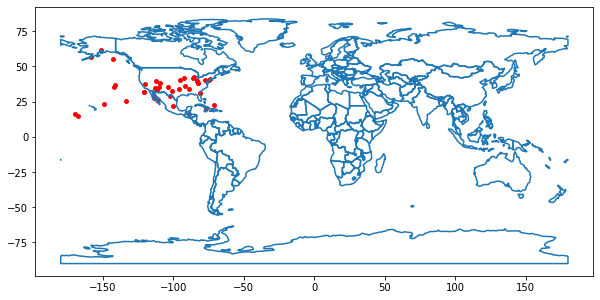

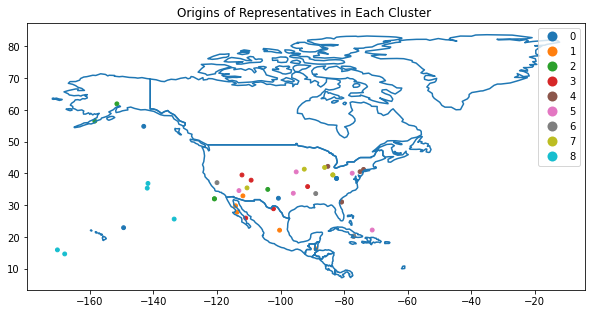

In [6]:
# plotting these latitude longitude values on a map with shapely and geopandas and making a graph for our origin representatives
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt


df = pd.DataFrame(origin_locations, columns =['latitude','longitude','cluster_id'])
#print(df)
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   
print(gdf)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world.continent == 'North America']
gdf.plot(ax=world.boundary.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);
gdf.plot(ax=north_america.boundary.plot(figsize=(10, 6)), marker='o', column='cluster_id',categorical=True, markersize=15, legend=True);
plt.title('Origins of Representatives in Each Cluster ')

     latitude   longitude  cluster_id                     geometry
0   27.231410  -87.106820           0   POINT (-87.10682 27.23141)
1   22.939833 -149.368270           0  POINT (-149.36827 22.93983)
2   43.844066 -120.877795           0  POINT (-120.87779 43.84407)
3   41.789318  -97.603882           0   POINT (-97.60388 41.78932)
4   22.939833 -149.368270           0  POINT (-149.36827 22.93983)
5   33.414901  -96.246397           1   POINT (-96.24640 33.41490)
6   16.187183  -88.032174           1   POINT (-88.03217 16.18718)
7   27.795030 -113.534903           1  POINT (-113.53490 27.79503)
8   16.268872  -88.854951           1   POINT (-88.85495 16.26887)
9   30.381628 -128.175351           1  POINT (-128.17535 30.38163)
10  38.636674  -92.744450           2   POINT (-92.74445 38.63667)
11  56.717969 -144.353117           2  POINT (-144.35312 56.71797)
12  31.779382  -93.606937           2   POINT (-93.60694 31.77938)
13  58.374768 -156.144221           2  POINT (-156.14422 58.37

Text(0.5, 1.0, 'Destinations of Representatives In Each Cluster')

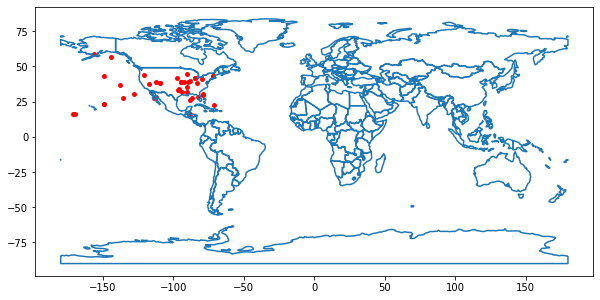

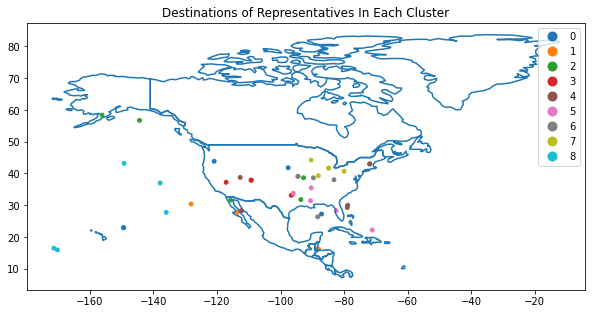

In [7]:
# plotting these latitude longitude values on a map with shapely and geopandas for our destination locations for each representative


df = pd.DataFrame(destination_locations, columns =['latitude','longitude','cluster_id'])
#print(df)
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   
print(gdf)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world.continent == 'North America']
gdf.plot(ax=world.boundary.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

gdf.plot(ax=north_america.boundary.plot(figsize=(10, 6)), marker='o', column='cluster_id',categorical=True, markersize=15, legend=True);

plt.title('Destinations of Representatives In Each Cluster')

## For each cluster, what is the delay distribution of elements within the cluster?

In [8]:
# grabbing mappings for each cluster for this configuration
if season !=4:
    mapping= spark.read.parquet('./../CURE_Mapping/k='+str(k)+'_season='+str(season)+'_num_reps='+str(num_reps)).coalesce(1)
else:
    # then we want all data
    mapping = spark.read.parquet('./../CURE_Mapping/k='+str(k)+'_season=EVERYTHING'+'_num_reps='+str(num_reps)).coalesce(1)
print(mapping.printSchema())

# getting dep delay mean for each cluster in our clustering
# also getting the number of elements in each cluster
# also getting percentages (number of records with delay/all records)
means = []
counts = []
percentages = []
for i in range(len(clusters)):
    if season !=4:
        interested_elements = mapping.where(mapping.tag==i).join(joined.where(joined.Season==season).coalesce(20),'record_id').coalesce(20)
        mean = interested_elements.select(F.mean('DepDelay')).collect()[0]
        num_delay = interested_elements.where(interested_elements.DepDelay>0).count()
    else:
        interested_elements = mapping.where(mapping.tag==i).join(joined.coalesce(20),'record_id').coalesce(20)
        mean = interested_elements.select(F.mean('DepDelay')).collect()[0]
        num_delay = interested_elements.where(interested_elements.DepDelay>0).count()
    print('cluster: '+ str(i)+ ' mean depdelay: ' + str(mean))
    means.append(mean['avg(DepDelay)'])
    count = mapping.where(mapping.tag==i).count()
    counts.append(count)
    percentages.append(num_delay/count)
    print('cluster: ' + str(i) + ' number of examples tagged: ' + str(count))
    print('cluster: ' + str(i) + ' number of records with delay: ' + str(num_delay))
    
    
    
    
# getting the mean dep delay for the population and the total count
if season!=4:
    pop_mean = joined.where(joined.Season==season).select(F.mean('depDelay')).collect()[0]['avg(depDelay)']
    pop_count = joined.where(joined.Season==season).count()
else:
    pop_mean  = joined.select(F.mean('depDelay')).collect()[0]['avg(depDelay)']
    pop_count = joined.count()
print('population_mean: ' + str(pop_mean))
print('population count: ' + str(pop_count))




root
 |-- record_id: long (nullable = true)
 |-- tag: integer (nullable = true)

None
cluster: 0 mean depdelay: Row(avg(DepDelay)=24.532966333283078)
cluster: 0 number of examples tagged: 683197
cluster: 0 number of records with delay: 383022
cluster: 1 mean depdelay: Row(avg(DepDelay)=-0.7630598631205059)
cluster: 1 number of examples tagged: 415548
cluster: 1 number of records with delay: 78354
cluster: 2 mean depdelay: Row(avg(DepDelay)=3.2502053611097397)
cluster: 2 number of examples tagged: 2025700
cluster: 2 number of records with delay: 734489
cluster: 3 mean depdelay: Row(avg(DepDelay)=1.0966479012707901)
cluster: 3 number of examples tagged: 1854122
cluster: 3 number of records with delay: 529396
cluster: 4 mean depdelay: Row(avg(DepDelay)=7.937864982787723)
cluster: 4 number of examples tagged: 1036179
cluster: 4 number of records with delay: 561996
cluster: 5 mean depdelay: Row(avg(DepDelay)=40.39482418265605)
cluster: 5 number of examples tagged: 1872284
cluster: 5 number 

## Plotting percentage of records with a delay per cluster

[]

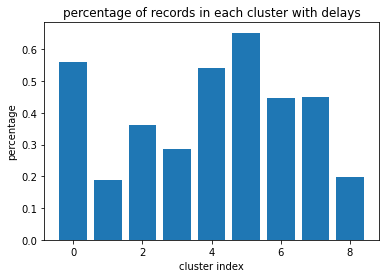

In [9]:
plt.bar([i for i in range(len(percentages))],percentages)
plt.xlabel('cluster index')
plt.ylabel('percentage')
plt.title('percentage of records in each cluster with delays')
plt.plot()

# Plotting number of examples per cluster

[]

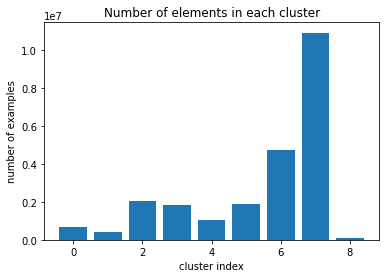

In [10]:
plt.bar([i for i in range(len(counts))],counts)
plt.xlabel('cluster index')
plt.ylabel('number of examples')
plt.title('Number of elements in each cluster')
plt.plot()

## Bar Plot for this Configuration

[]

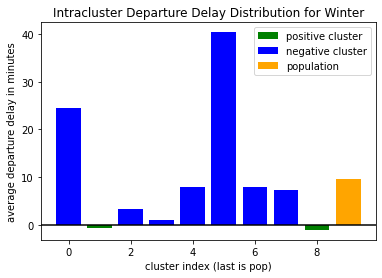

In [11]:

fig = plt.figure()
ax = plt.subplot(111)
positives = []
negatives  = []
for i in range(len(means)):
    if means[i]<0:
        negatives.append((i,means[i]))
    else:
        positives.append((i,means[i]))
#print(zip(*negatives))
first = ax.bar([index for index,value in negatives], [value for index,value in negatives],color='green')
second = ax.bar([index for index,value in positives], [value for index,value in positives],color='blue')
third = ax.bar([len(means)],[pop_mean],color='orange')
ax.axhline(0, color='k')
ax.legend((first,second,third),('positive cluster','negative cluster','population'))
plt.xlabel('cluster index (last is pop)')
plt.ylabel('average departure delay in minutes')
plt.title('Intracluster Departure Delay Distribution for Winter')
plt.plot()

## Cluster analysis for Cluster 5 (highest average delay in minutes)

In [12]:
# intracluster analysis
cluster_index = 5

if season!=4:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.where(joined.Season==season).coalesce(20),'record_id')\
                                                                    .drop('Season','record_id','tag').coalesce(80)
    pop = joined.where(joined.Season==season).drop('Season','record_id')
    pop_stats = pop.select(*[[F.mean(c).alias(c+'_mean') for c in pop.columns] + \
                                     [F.stddev_pop(c).alias(c+'_stddev') for c in pop.columns]]).collect()[0]
else:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined,'record_id').drop('Season','record_id','tag').coalesce(20)
    pop_stats = stats

interested_stats = interested_elements\
                                        .select(*[[F.mean(c).alias(c+'_mean') for c in interested_elements.columns] + \
                                        [F.stddev_pop(c).alias(c+'_stddev') for c in interested_elements.columns]]).collect()[0]

print('interested_stats: ' + str(interested_stats))
print('pop_stats: ' + str(pop_stats))

interested_stats: Row(ArrDelay_mean=42.259963766180775, DepDelay_mean=40.39482418265605, ActualElapsedTime_mean=165.31324681511992, Distance_mean=1007.9368909844874, origin_lat_mean=38.685050552754305, origin_long_mean=-86.59054913656762, dest_lat_mean=30.884800411619977, dest_long_mean=-87.64901265696105, origin_prcp_mean=23.050265878467155, origin_tmax_mean=61.939977588870065, origin_tmin_mean=-32.03242296574665, origin_awnd_mean=44.258134449688185, dest_prcp_mean=21.21843427599659, dest_tmax_mean=193.39838240352424, dest_tmin_mean=87.48013228762304, dest_awnd_mean=40.46627594958884, ArrDelay_stddev=63.703234094774764, DepDelay_stddev=58.392022589170416, ActualElapsedTime_stddev=55.88667103550942, Distance_stddev=457.49878881542014, origin_lat_stddev=4.5509332483068565, origin_long_stddev=13.323770496530674, dest_lat_stddev=5.772590682078667, dest_long_stddev=13.429208421465756, origin_prcp_stddev=60.66670954703077, origin_tmax_stddev=97.59933228707628, origin_tmin_stddev=91.36704901

## Plotting stats compared to average for delay attributes

In [13]:


# defining a function to make plots for us
def plot_features(labels,title,interested_stats,pop_stats):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    interested_vals = [interested_stats[label+'_mean'] for label in labels]
    interested_stddevs = [interested_stats[label+'_stddev'] for label in labels]
    pop_vals = [pop_stats[label+'_mean'] for label in labels]
    pop_stddevs = [pop_stats[label+'_stddev'] for label in labels]
    indices = np.arange(len(pop_vals))
    width = 0.35
    first = ax.bar(indices,interested_vals,width,label='cluster',yerr=interested_stddevs)
    second = ax.bar(indices+width,pop_vals,width,label='population',yerr=pop_stddevs)
    ax.set_xticks(indices+width/2)
    ax.set_xticklabels(labels)
    plt.ylabel('value')
    plt.xlabel('feature')
    ax.legend((first,second),('Cluster','Population'))
    plt.title(title)
    plt.plot()

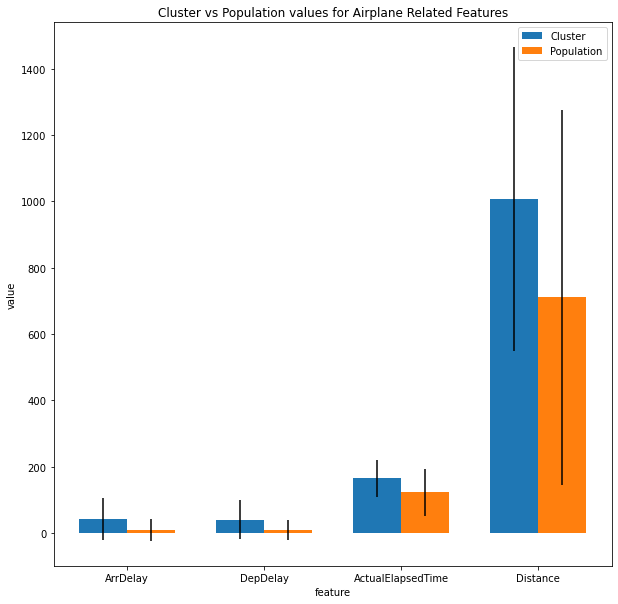

In [14]:
# flight related features
labels = ['ArrDelay', 'DepDelay', 'ActualElapsedTime', 'Distance']
title = 'Cluster vs Population values for Airplane Related Features'
plot_features(labels,title,interested_stats,pop_stats)

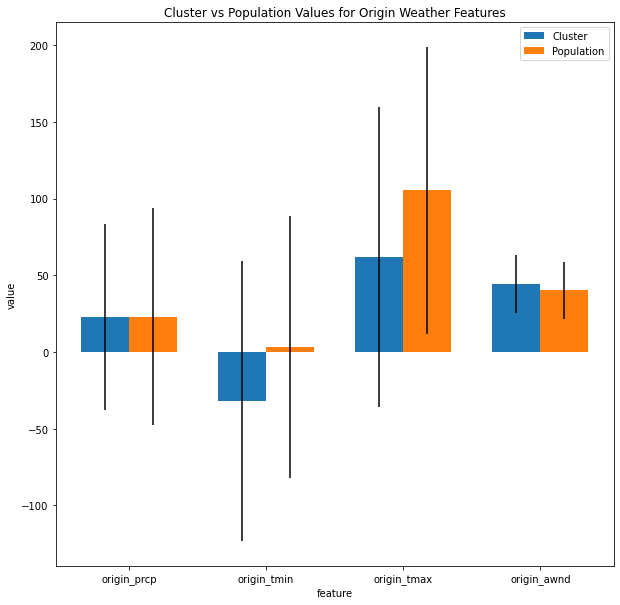

In [15]:
# weather related features for origin
labels = ['origin_prcp','origin_tmin','origin_tmax','origin_awnd']
title = 'Cluster vs Population Values for Origin Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

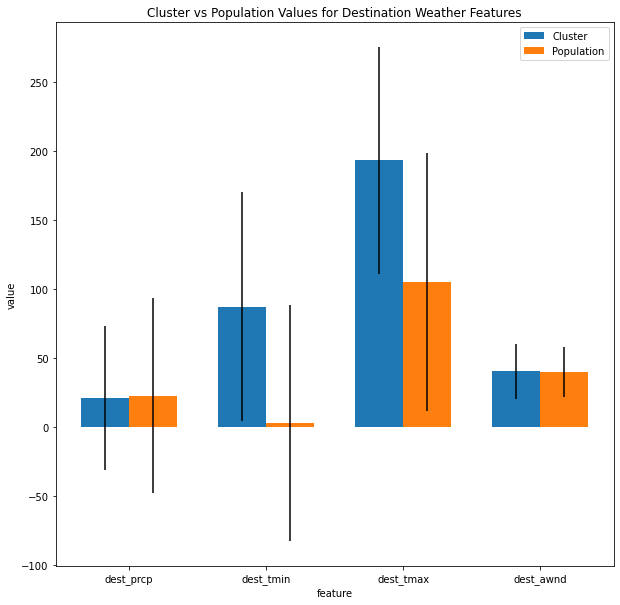

In [16]:
# weather related features for destination
labels = ['dest_prcp','dest_tmin','dest_tmax','dest_awnd']
title = 'Cluster vs Population Values for Destination Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

## Delays in this cluster seems to be from flights that are generally longer than average, and moving from colder regions to warmer ones. We can see in the map that the destinations are situated more south than the origins (warmer weathers)

## Analyzing the other cluster with delays: cluster 0

In [17]:
# intracluster analysis
cluster_index = 0

if season!=4:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.where(joined.Season==season).coalesce(20),'record_id')\
                                                                    .drop('Season','record_id','tag').coalesce(80)
else:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined,'record_id').drop('Season','record_id','tag').coalesce(20)


interested_stats = interested_elements\
                                        .select(*[[F.mean(c).alias(c+'_mean') for c in interested_elements.columns] + \
                                        [F.stddev_pop(c).alias(c+'_stddev') for c in interested_elements.columns]]).collect()[0]

print('interested_stats: ' + str(interested_stats))
print('pop_stats: ' + str(pop_stats))

interested_stats: Row(ArrDelay_mean=24.907566924327828, DepDelay_mean=24.532966333283078, ActualElapsedTime_mean=170.20027312766302, Distance_mean=1135.0575953934224, origin_lat_mean=35.164648324359106, origin_long_mean=-102.91905603679996, dest_lat_mean=33.59905678854348, dest_long_mean=-103.35756825870969, origin_prcp_mean=228.44758393259923, origin_tmax_mean=136.46313581587742, origin_tmin_mean=55.60382876388509, origin_awnd_mean=41.478179792944054, dest_prcp_mean=58.481941519064044, dest_tmax_mean=160.18254032145927, dest_tmin_mean=68.01526792418585, dest_awnd_mean=41.39605999440864, ArrDelay_stddev=57.52259182743713, DepDelay_stddev=54.81678336595845, ActualElapsedTime_stddev=121.6189568404938, Distance_stddev=1059.347304329281, origin_lat_stddev=7.491323556245831, origin_long_stddev=23.989095414349006, dest_lat_stddev=7.496725551184109, dest_long_stddev=25.778021694755132, origin_prcp_stddev=203.0375880661675, origin_tmax_stddev=88.76388526377723, origin_tmin_stddev=88.4360923223

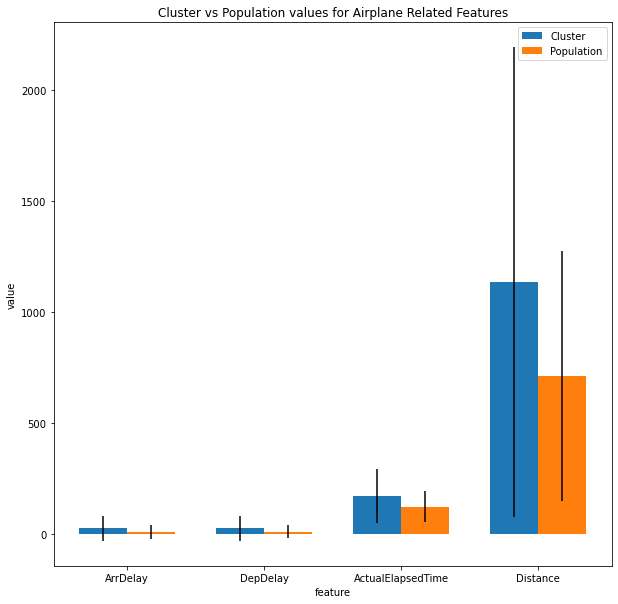

In [18]:
# flight related features
labels = ['ArrDelay', 'DepDelay', 'ActualElapsedTime', 'Distance']
title = 'Cluster vs Population values for Airplane Related Features'
plot_features(labels,title,interested_stats,pop_stats)

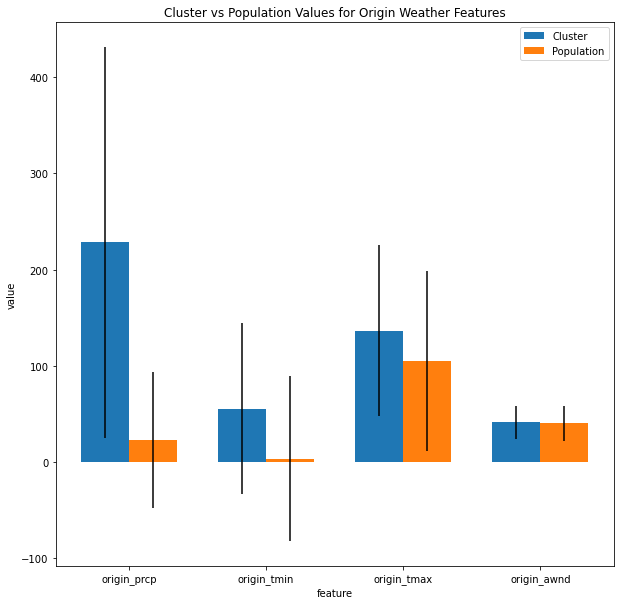

In [19]:
# weather related features for origin
labels = ['origin_prcp','origin_tmin','origin_tmax','origin_awnd']
title = 'Cluster vs Population Values for Origin Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

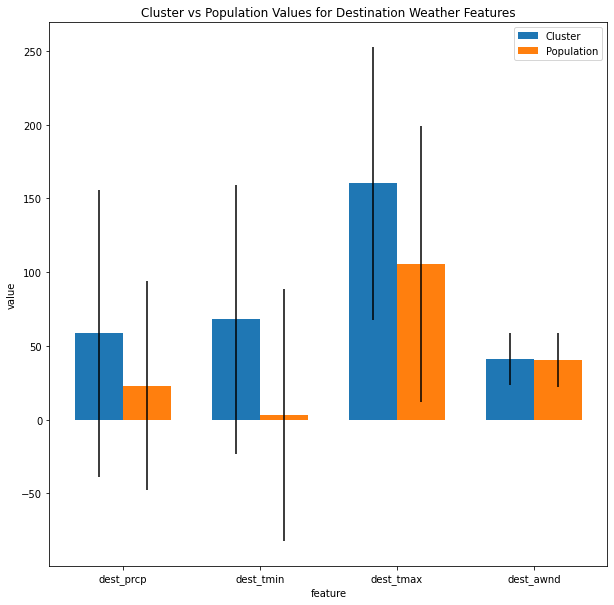

In [20]:
# weather related features for destination
labels = ['dest_prcp','dest_tmin','dest_tmax','dest_awnd']
title = 'Cluster vs Population Values for Destination Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

# We see that these flights involve temperature regions higher than average,the flights are longer than average, and the delays seem to be attributed to large amounts of precipitation at the origin point of the flight

## What about the cluster with no delays? Cluster 8 (flights are actually departing early on average for this cluster)

In [21]:
# intracluster analysis
cluster_index = 8

if season!=4:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.where(joined.Season==season).coalesce(20),'record_id')\
                                                                    .drop('Season','record_id','tag').coalesce(80)
else:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined,'record_id').drop('Season','record_id','tag').coalesce(20)


interested_stats = interested_elements\
                                        .select(*[[F.mean(c).alias(c+'_mean') for c in interested_elements.columns] + \
                                        [F.stddev_pop(c).alias(c+'_stddev') for c in interested_elements.columns]]).collect()[0]

print('interested_stats: ' + str(interested_stats))
print('pop_stats: ' + str(pop_stats))

interested_stats: Row(ArrDelay_mean=-1.065415000951837, DepDelay_mean=-1.0695435941366838, ActualElapsedTime_mean=39.36310203693128, Distance_mean=133.6245835712926, origin_lat_mean=22.55694601375315, origin_long_mean=-156.12131380530445, dest_lat_mean=22.595394241471716, dest_long_mean=-156.14145642521834, origin_prcp_mean=29.244074814391777, origin_tmax_mean=257.81737816485816, origin_tmin_mean=181.4575480677708, origin_awnd_mean=43.95413335237007, dest_prcp_mean=30.50550875690082, dest_tmax_mean=258.4733961545783, dest_tmin_mean=182.95935655815725, dest_awnd_mean=44.47540691033695, ArrDelay_stddev=14.215575957518515, DepDelay_stddev=12.28997676598247, ActualElapsedTime_stddev=13.959130695153759, Distance_stddev=95.07082080511739, origin_lat_stddev=6.465197956814777, origin_long_stddev=6.729300611499741, dest_lat_stddev=6.503533369325108, dest_long_stddev=6.636702528361416, origin_prcp_stddev=88.48328501328683, origin_tmax_stddev=51.86450472701788, origin_tmin_stddev=54.0655147875971

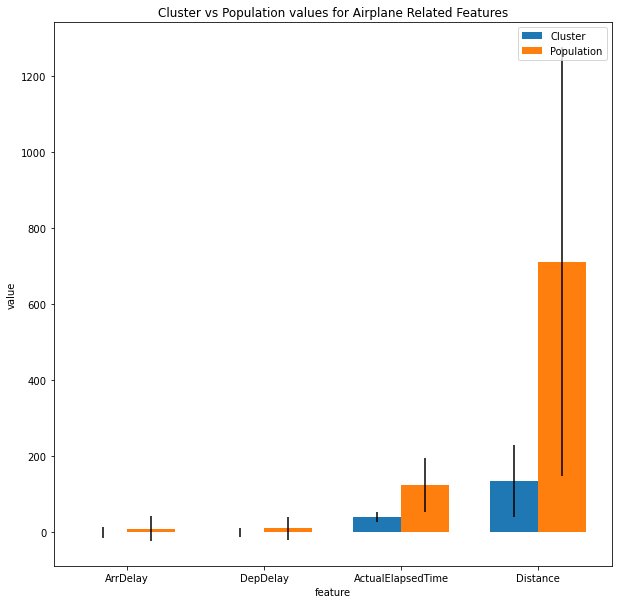

In [22]:
# flight related features
labels = ['ArrDelay', 'DepDelay', 'ActualElapsedTime', 'Distance']
title = 'Cluster vs Population values for Airplane Related Features'
plot_features(labels,title,interested_stats,pop_stats)

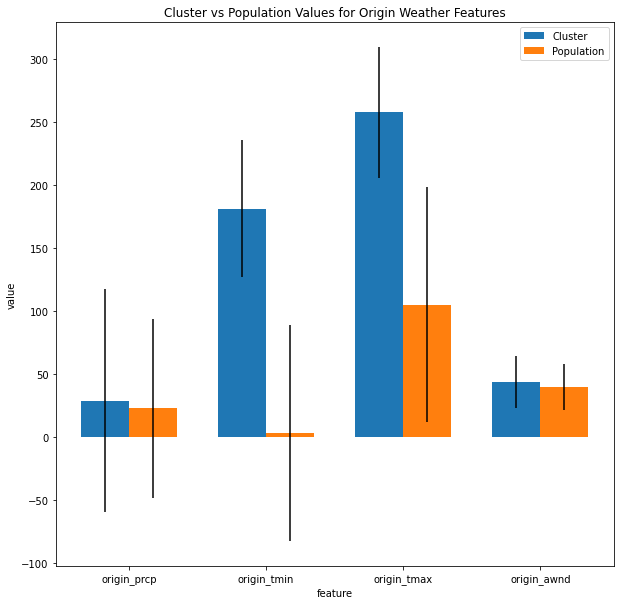

In [23]:
# weather related features for origin
labels = ['origin_prcp','origin_tmin','origin_tmax','origin_awnd']
title = 'Cluster vs Population Values for Origin Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

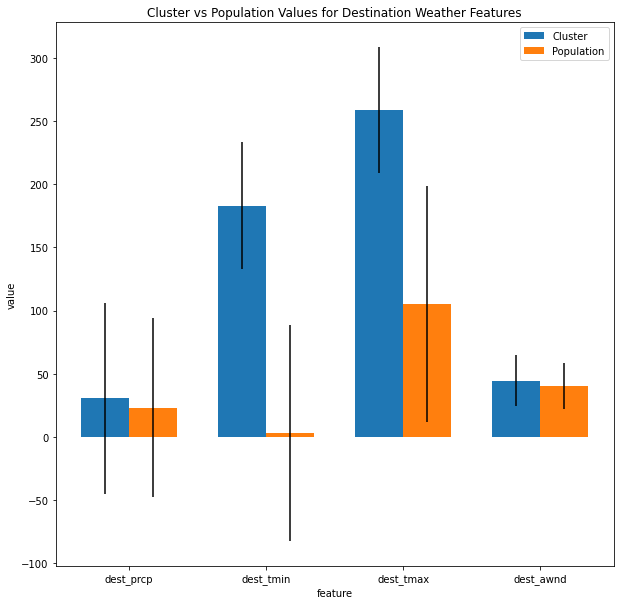

In [24]:
# weather related features for destination
labels = ['dest_prcp','dest_tmin','dest_tmax','dest_awnd']
title = 'Cluster vs Population Values for Destination Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

## The clusters with practically no delays involve really short flights in the system

# Analyzing the cluster also with very low average delay: Cluster 1

In [25]:
# intracluster analysis
cluster_index = 1

if season!=4:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.where(joined.Season==season).coalesce(20),'record_id')\
                                                                    .drop('Season','record_id','tag').coalesce(80)
else:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined,'record_id').drop('Season','record_id','tag').coalesce(20)


interested_stats = interested_elements\
                                        .select(*[[F.mean(c).alias(c+'_mean') for c in interested_elements.columns] + \
                                        [F.stddev_pop(c).alias(c+'_stddev') for c in interested_elements.columns]]).collect()[0]

print('interested_stats: ' + str(interested_stats))
print('pop_stats: ' + str(pop_stats))

interested_stats: Row(ArrDelay_mean=-5.583932542089, DepDelay_mean=-0.7630598631205059, ActualElapsedTime_mean=75.56830979814606, Distance_mean=382.3080775265433, origin_lat_mean=34.94189551129475, origin_long_mean=-112.7748986235069, dest_lat_mean=35.35647375541641, dest_long_mean=-112.33224599971095, origin_prcp_mean=3.617172986032901, origin_tmax_mean=163.77499350255567, origin_tmin_mean=51.87603116848114, origin_awnd_mean=31.722729985464976, dest_prcp_mean=1.742369112593491, dest_tmax_mean=150.69521932484335, dest_tmin_mean=20.54826397913117, dest_awnd_mean=16.859012677235842, ArrDelay_stddev=10.512346205300009, DepDelay_stddev=5.8239347630743605, ActualElapsedTime_stddev=23.710942597935816, Distance_stddev=190.8827243257005, origin_lat_stddev=3.142181628835283, origin_long_stddev=10.143789898055198, dest_lat_stddev=2.907214144642299, dest_long_stddev=11.118682786317372, origin_prcp_stddev=18.334984117209462, origin_tmax_stddev=56.58126876313776, origin_tmin_stddev=52.8016743421075

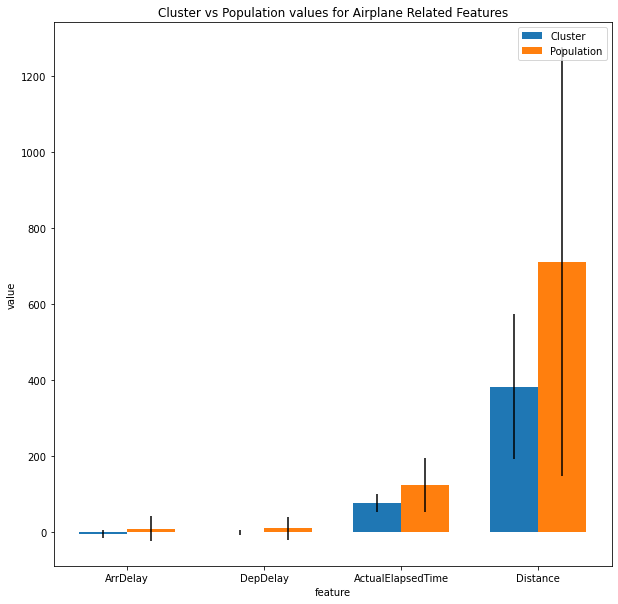

In [26]:
# flight related features
labels = ['ArrDelay', 'DepDelay', 'ActualElapsedTime', 'Distance']
title = 'Cluster vs Population values for Airplane Related Features'
plot_features(labels,title,interested_stats,pop_stats)

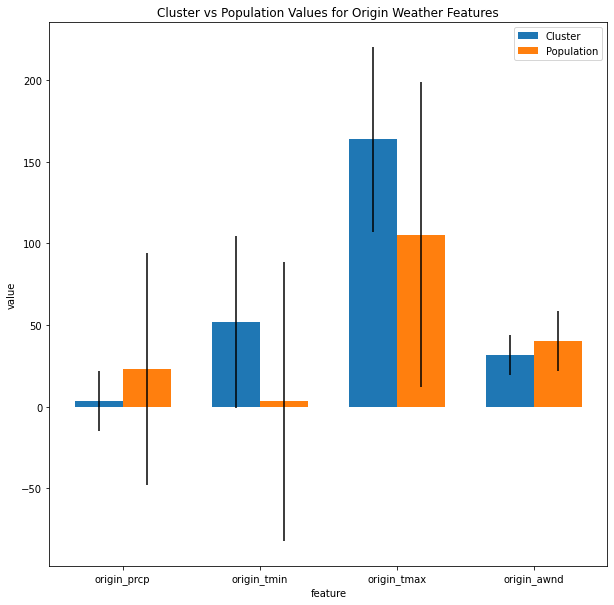

In [27]:
# weather related features for origin
labels = ['origin_prcp','origin_tmin','origin_tmax','origin_awnd']
title = 'Cluster vs Population Values for Origin Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

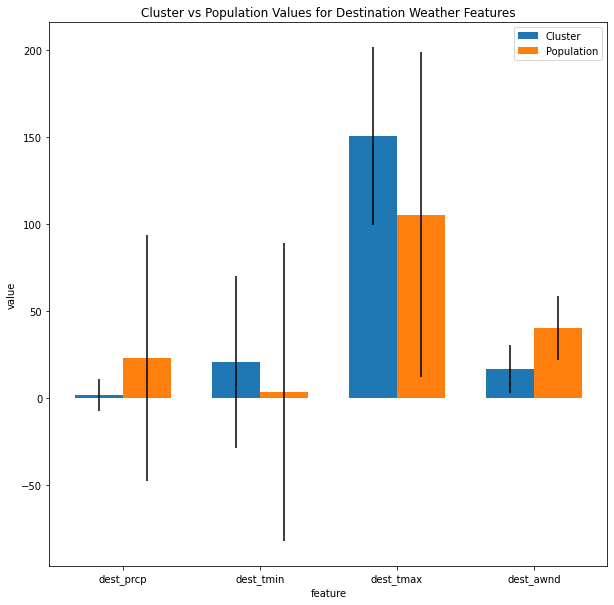

In [28]:
# weather related features for destination
labels = ['dest_prcp','dest_tmin','dest_tmax','dest_awnd']
title = 'Cluster vs Population Values for Destination Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

## We see a similar thing here, with flights being much shorter than average with little to no precipitation and higher temperatures. Seems to correspond to southern regions of the United States.